# ViT test code

In [1]:
!nvidia-smi

Sun Jan 28 23:07:04 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA T600 Lap...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8     4W /  35W |   3870MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## classify
dataset : https://www.kaggle.com/jessicali9530/stanford-dogs-dataset

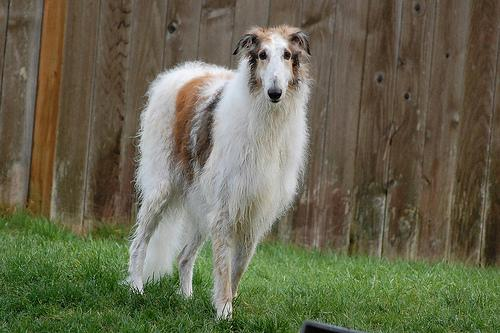

In [6]:
from PIL import Image
import requests
import matplotlib.pyplot as plt

#url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
file_path = '/workspace/data/images/Images/n02090622-borzoi/n02090622_5556.jpg'
image = Image.open(file_path)
image

## CPU process

In [7]:
import torch
from transformers import ViTForImageClassification, ViTFeatureExtractor
from transformers import ViTImageProcessor

# モデルと特徴抽出器の準備
model_1 = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
feature_extractor_1 = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

# 画像をテンソルに変換
inputs = feature_extractor_1(images=image, return_tensors='pt')
# 推論
outputs = model_1(**inputs)
logits = outputs.logits # 1000クラスのスコアの配列
predicted_class_idx = logits.argmax(-1).item() # スコアが最大のインデックス
print('class:', model_1.config.id2label[predicted_class_idx]) # インデックスをラベルに変換

class: borzoi, Russian wolfhound


## GPU process

In [10]:
import torch
from transformers import ViTForImageClassification, ViTFeatureExtractor, ViTImageProcessor

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# モデルと特徴抽出器の準備（T600 4GB メモリ不足 ）
#model_1 = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to(device)
#feature_extractor_1 = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

# smallモデル
model_1 = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k').to(device)
feature_extractor_1 = ViTFeatureExtractor.from_pretrained('google/vit-small-patch16-224-in21k')

# 画像をテンソルに変換し、GPUに移動
inputs = feature_extractor_1(images=image, return_tensors='pt').to(device)

# 推論
outputs = model_1(**inputs)
logits = outputs.logits # 1000クラスのスコアの配列
predicted_class_idx = logits.argmax(-1).item() # スコアが最大のインデックス
print('class:', model_1.config.id2label[predicted_class_idx]) # インデックスをラベルに変換


/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
